In [3]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorythm used
from sklearn.cluster import  KMeans

# Evaluation Metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Ignore Warnings
import warnings
warnings.simplefilter("ignore")


In [4]:
X_train = pd.read_csv('X_train_cluster.csv')
X_val = pd.read_csv('X_val_cluster.csv')
X_test = pd.read_csv('X_test_cluster.csv')

### As seen below, optimal number of clusters is 4

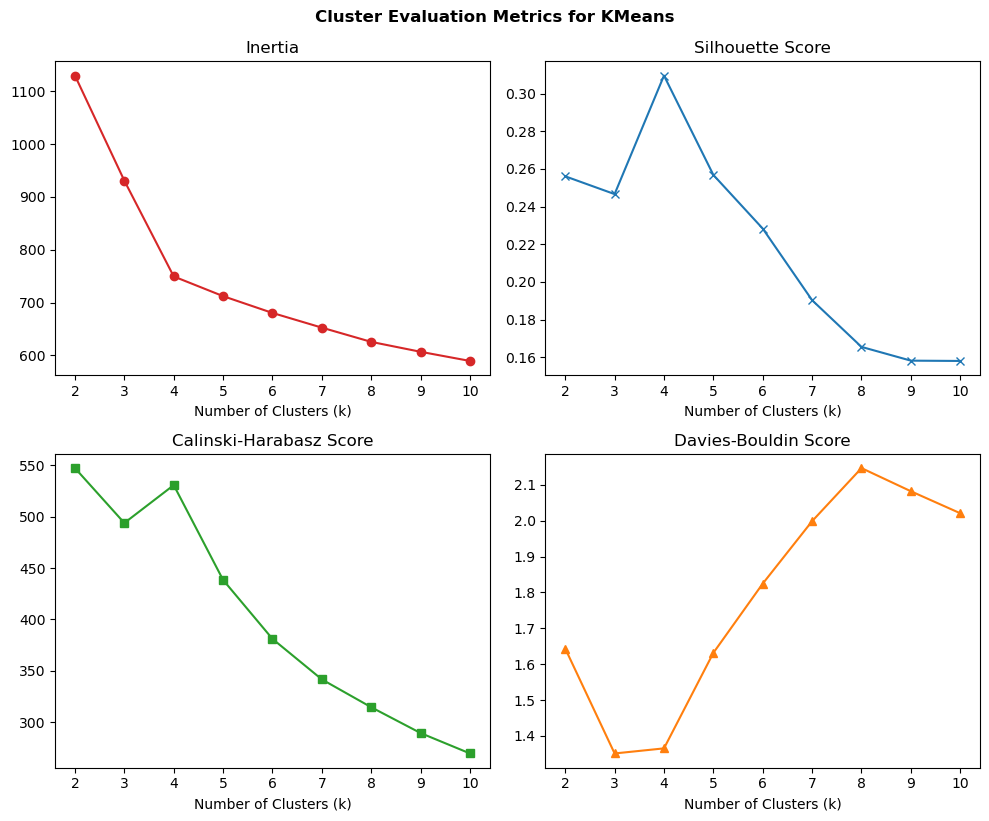

In [5]:
# Fit KMeans on evaluation set and get relevant scores to find the best number of clusters

inertia_values = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

for i in range(2, 11):  # Trying k values from 2 to 10
    km = KMeans(n_clusters=i)
    km.fit(X_val)
    
    inertia_values.append(km.inertia_)
    
    silhouette_avg = silhouette_score(X_val, km.labels_)
    silhouette_scores.append(silhouette_avg)
    
    calinski_harabasz_avg = calinski_harabasz_score(X_val, km.labels_)
    calinski_harabasz_scores.append(calinski_harabasz_avg)
    
    davies_bouldin_avg = davies_bouldin_score(X_val, km.labels_)
    davies_bouldin_scores.append(davies_bouldin_avg)

# Create a 2x2 dashboard
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot Inertia
axes[0, 0].plot(range(2, 11), inertia_values, color='tab:red', marker='o')
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_title('Inertia')

# Plot Silhouette Score
axes[0, 1].plot(range(2, 11), silhouette_scores, color='tab:blue', marker='x')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_title('Silhouette Score')

# Plot Calinski-Harabasz Score
axes[1, 0].plot(range(2, 11), calinski_harabasz_scores, color='tab:green', marker='s')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_title('Calinski-Harabasz Score')


# Plot Davies-Bouldin Score
axes[1, 1].plot(range(2, 11), davies_bouldin_scores, color='tab:orange', marker='^')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_title('Davies-Bouldin Score')


plt.tight_layout()
plt.suptitle('Cluster Evaluation Metrics for KMeans', y=1.02, fontweight='bold')
plt.show()

In [6]:
# Merge X_train and X_val as our final training dataset
final_df = pd.concat([X_train, X_val], axis=0)

In [7]:
# This is the final model. Fit it on the data just to ensure robustness

model = KMeans(n_clusters=4)
model.fit(final_df)

inertia = model.inertia_
labels = model.labels_

silhouette = silhouette_score(final_df, labels)
calinski_harabasz = calinski_harabasz_score(final_df, labels)
davies_bouldin = davies_bouldin_score(final_df, labels)
    
print("Inertia:", inertia)
print("Silhouette Score:", silhouette)
print("Calinski Harabasz Score:", calinski_harabasz)
print("Davies Bouldin Score:", davies_bouldin)

Inertia: 4278.431585688422
Silhouette Score: 0.3087673678611763
Calinski Harabasz Score: 2978.4423628096406
Davies Bouldin Score: 1.3723072336824869


### Below are some plots to visualize centroid values

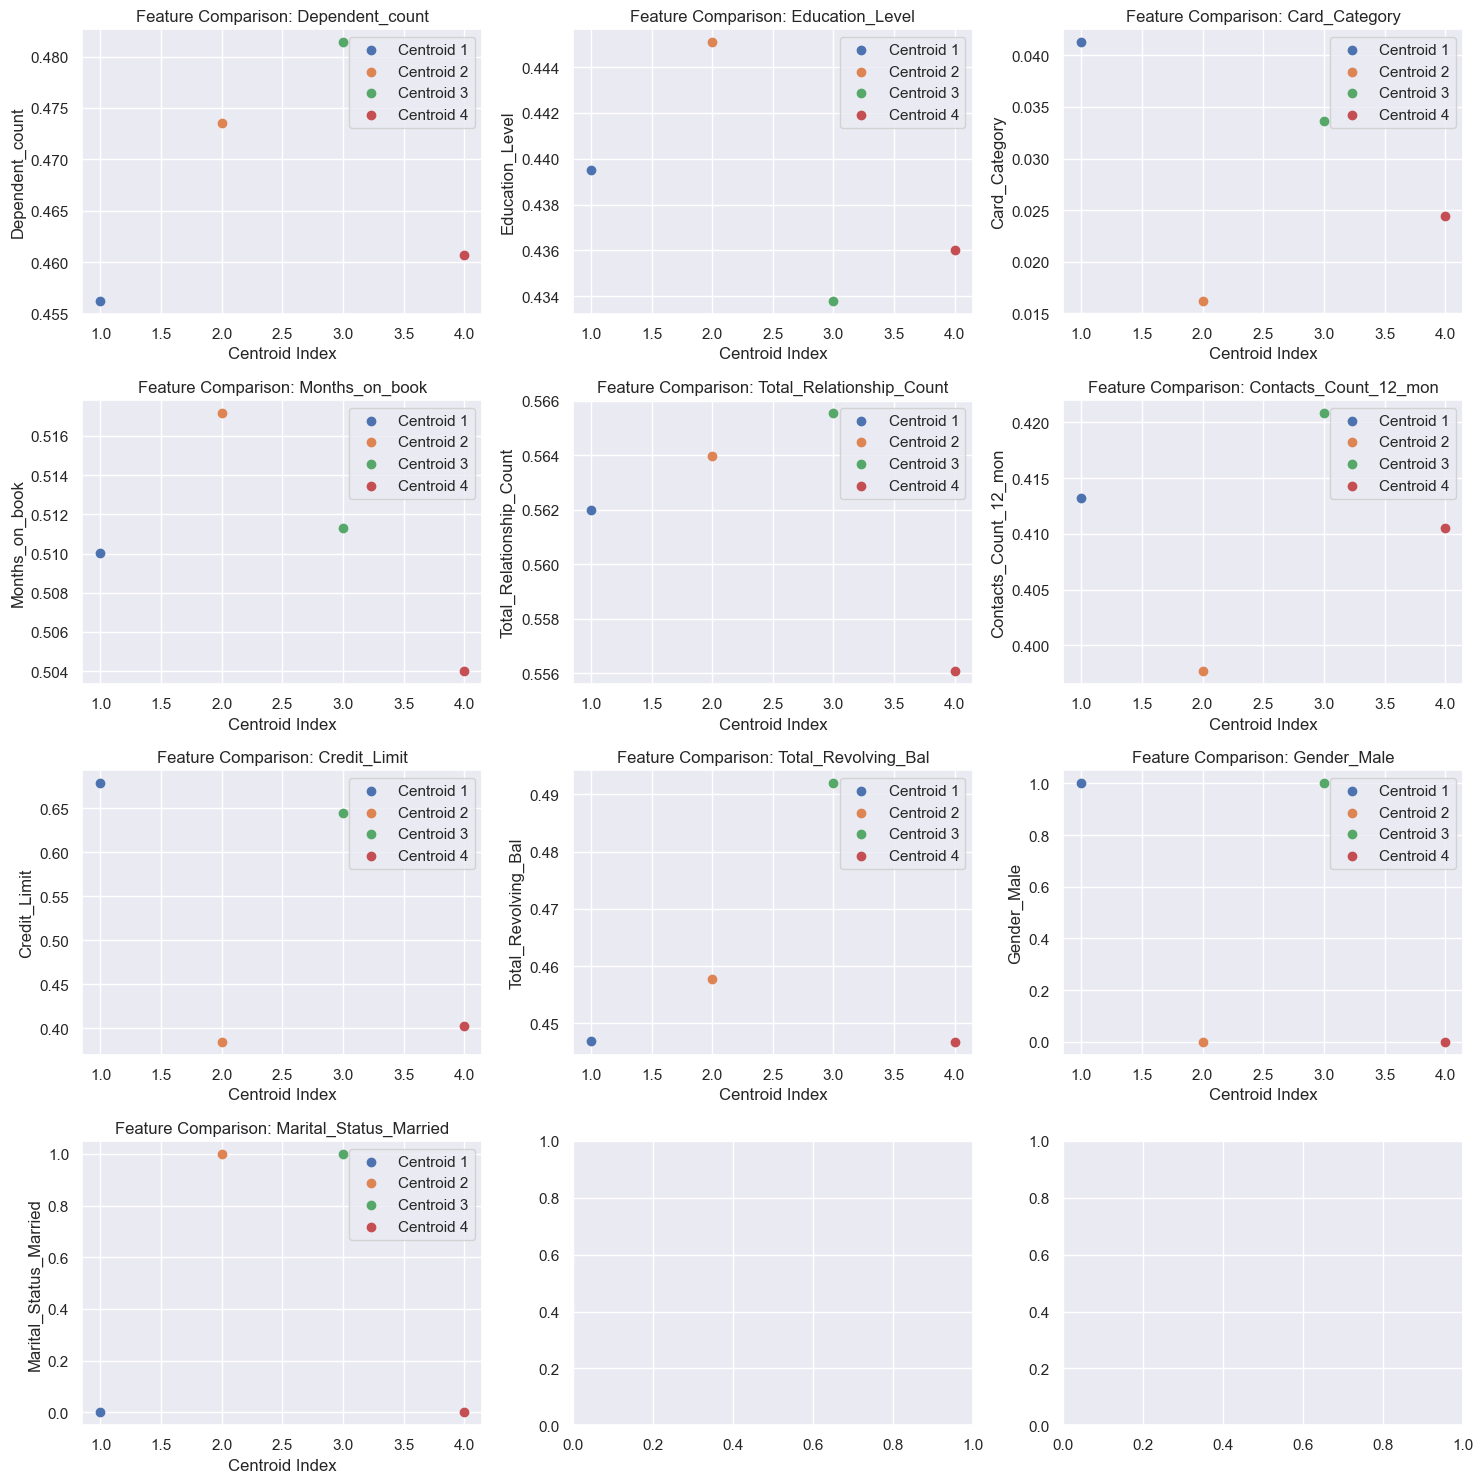

In [16]:
# Get centroids
centroids = model.cluster_centers_

# Define feature names
feature_names = ['Dependent_count', 'Education_Level', 'Card_Category', 'Months_on_book',
                 'Total_Relationship_Count', 'Contacts_Count_12_mon', 'Credit_Limit',
                 'Total_Revolving_Bal', 'Gender_Male', 'Marital_Status_Married']

sns.set(style="darkgrid")

# Set up subplot grid
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, ax in enumerate(axes):
    # Check if the current index is within the valid range
    if i < len(feature_names):
        for centroid_index in range(centroids.shape[0]):
            ax.scatter(centroid_index + 1, centroids[centroid_index, i], label=f'Centroid {centroid_index + 1}')

        ax.set_xlabel('Centroid Index')
        ax.set_ylabel(feature_names[i])
        ax.set_title(f'Feature Comparison: {feature_names[i]}')
        ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


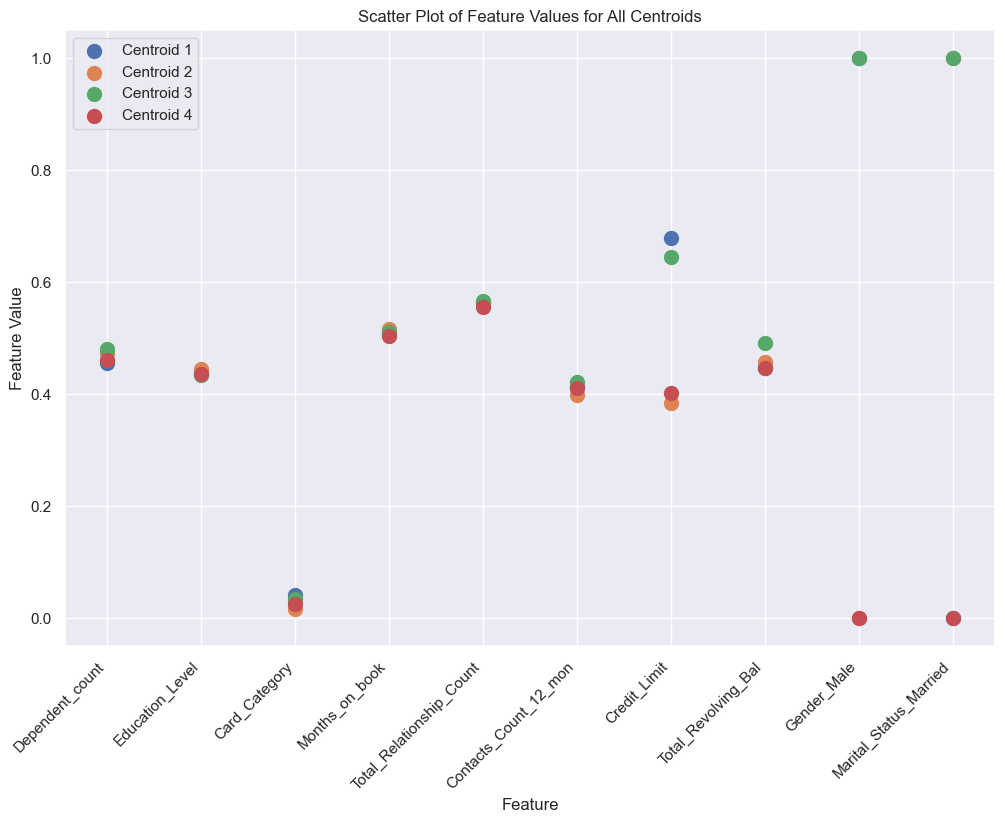

In [17]:
# Set up a scatter plot for all centroids
plt.figure(figsize=(12, 8))

# Iterate through centroids and plot scatter for each feature
for centroid_index in range(centroids.shape[0]):
    centroid_values = centroids[centroid_index, :]
    plt.scatter(np.arange(len(feature_names)) + 1, centroid_values, label=f'Centroid {centroid_index + 1}', alpha=1, s=100)

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Feature Value')
plt.title('Scatter Plot of Feature Values for All Centroids')

# Add x-axis ticks with feature names
plt.xticks(np.arange(len(feature_names)) + 1, feature_names, rotation=45, ha='right')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [19]:
# Add 'cluster' column to the DataFrame
final_df['cluster'] = model.labels_

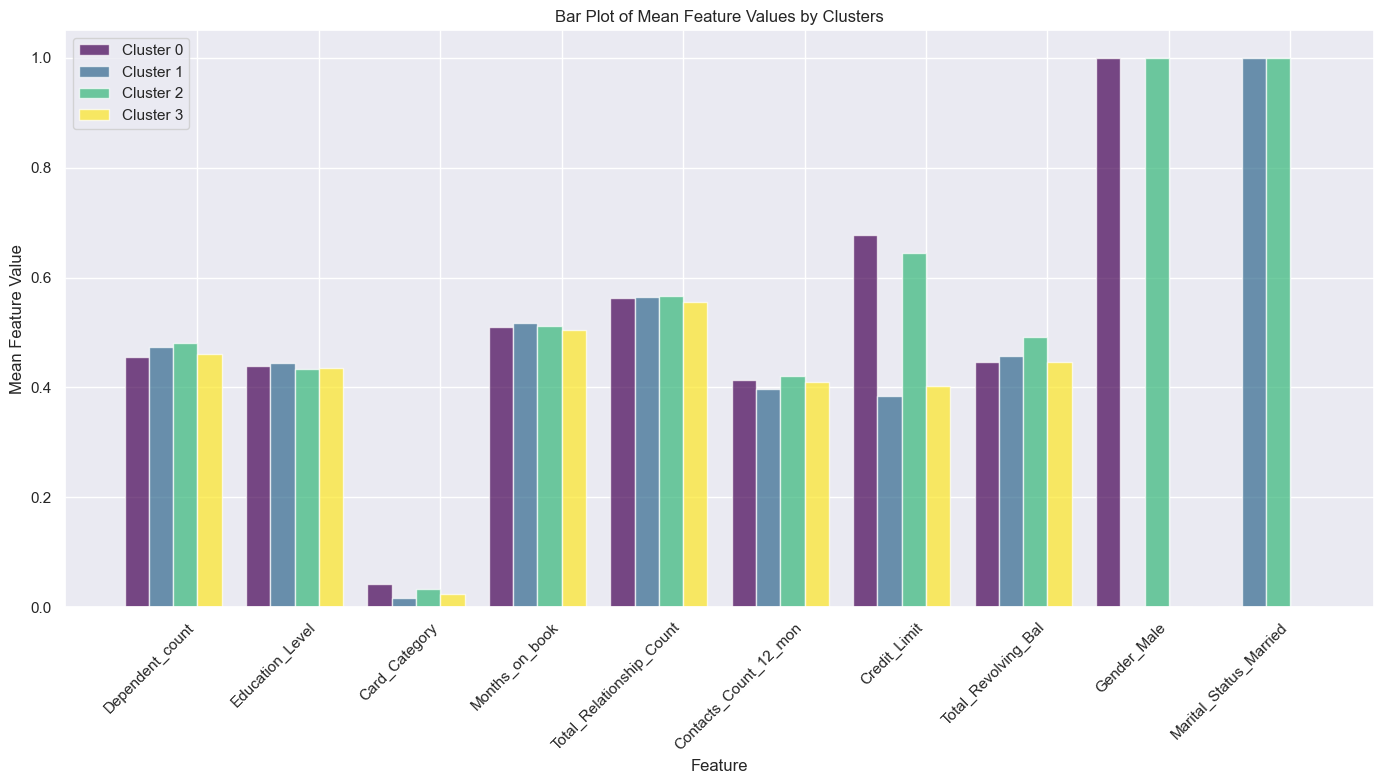

In [20]:
# Set up a bar plot for the mean values of each feature, grouped by clusters
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors for each cluster using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Iterate through features and plot grouped bars for each cluster
bar_width = 0.2
for i, feature in enumerate(feature_names):
    for cluster_label in range(4):
        cluster_data = final_df[final_df['cluster'] == cluster_label]
        cluster_means = np.mean(cluster_data[feature])
        ax.bar(i + (cluster_label - 2) * bar_width, cluster_means, width=bar_width, alpha=0.7, color=colors[cluster_label])

# Add labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Mean Feature Value')
ax.set_title('Bar Plot of Mean Feature Values by Clusters')
ax.set_xticks(np.arange(len(feature_names)) + bar_width / 2)
ax.set_xticklabels(feature_names, rotation=45, ha='right')

# Add legend outside the loop to ensure it appears only once
legend_labels = [f'Cluster {cluster_label}' for cluster_label in range(4)]
ax.legend(legend_labels, loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion

### In the end, we can see that there are no underlying patterns in the data. Clusters cannot be formed to give enough business value. What can be said is that people have too complex of spending behaviors(or too simple) to be classified based on these features. In a bank setting, customers should be categorized and targetted through marketing based mainly on credit limit and the card category they own, while gender can also be an indicator worth considering.
### However, deep diving into this data gave some interesting results:
- ### Men have a considerably higher credit limit and are generally categorized on the higher end of income categories.
- ### Marital Status is not a statistically important indicator of wealth.
- ### Higher Education does not directly impact spending habits.